# Visualizing the saliency maps

Once your classifier is trained you can visualize which pixels where the most relevant to classify an image as a certain label. This is what we call the *saliency maps*.

We will use the implementations of different saliency functions from the [deep-viz repository](https://github.com/experiencor/deep-viz-keras) by [experiencor](https://github.com/experiencor) which allows the visualization of saliency maps for keras models.

**Remarks:** For some reason the code seems to fail when using the `Xception` architecture. `ResNet` for example, works fine though.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, load_class_names, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2022-04-19_Fold1SpAnd45Balanced_18ep_stop_16Batch'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load the data
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=True)

Loading class names...


Now you can select a file in your computer in which to visualize the saliency maps. 
Possible visualizations include:
* [Vanila gradient](https://arxiv.org/abs/1312.6034)
* [Guided backprop](https://arxiv.org/abs/1412.6806)
* [Integrated gradients](https://arxiv.org/abs/1703.01365)
* [Visual backprop](https://arxiv.org/abs/1611.05418)

Each of them is accompanied with the corresponding [smoothgrad](https://arxiv.org/abs/1706.03825) version, which improves on any baseline method by adding random noise.

In [6]:
cd ..

/srv


[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 4s 4s/step
Top predicted labels:
[85.9%] sinuoso
[14.1%] no sinuoso


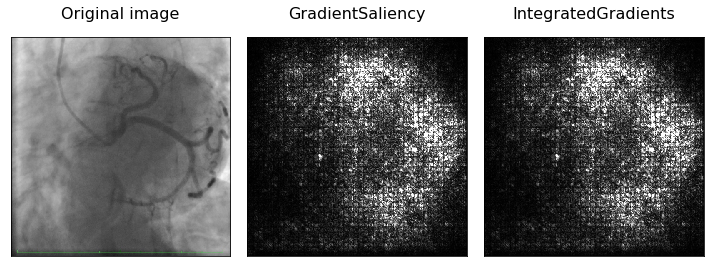

In [9]:
FILEPATH = '/srv/datos/ENVIO_ABRIL/No_tortuosos/No_tortuosos_spider/5990_SPIDER_n.jpg'
saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error
# solo deberiamos usar Gradients y GRadCAM de acuerdo con el paper 
# citado en https://glassboxmedicine.com/2019/10/12/guided-grad-cam-is-broken-sanity-checks-for-saliency-maps/
figsize = 5
fig, axs = plt.subplots(1, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)), figsize))
axbig=axs[0]

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])

axbig.imshow(image)
axbig.set_title('Original image', fontsize=16, pad=18)
axbig.set_xticks([])
axbig.set_yticks([])
axbig.xaxis.set_visible(False)
axbig.yaxis.set_visible(False)
axs = axs.T.flatten()
# fig.delaxes(axs[1])
axs = axs[1:]

# Saliency maps
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i].set_title(saliency_func.__class__.__name__, fontsize=16, pad=18)

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.set_label_position("right")

fig.tight_layout(pad=1.0)
# plt.savefig('/srv/image-results/saliencyMaps_5990_SPIDER_n.png',bbox_inches='tight')
    
# Print predicted labels
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K)#, filemode='local')
print('Top predicted labels:')
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 4s 4s/step
Top predicted labels:
[99.9%] sinuoso
[0.1%] no sinuoso


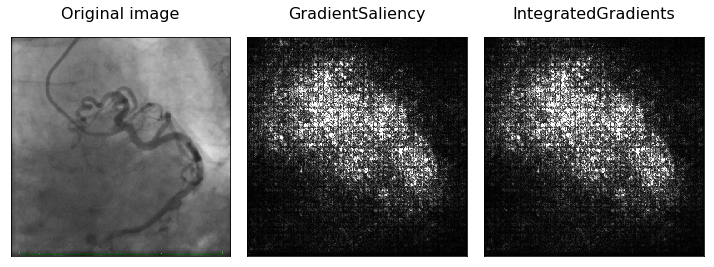

In [10]:
FILEPATH = '/srv/datos/ENVIO_ABRIL/Tortuosos/Tortuosos_spider/2614_SPIDER_s.jpg'
saliency_types = [GradientSaliency, IntegratedGradients]#, VisualBackprop] # --> VisualBackprop seems to give errors
# https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

figsize = 5
fig, axs = plt.subplots(1, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)), figsize))
axbig=axs[0]

# Load the image and preprocess it for the saliency maps computation
data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

img_arr = data_gen.__getitem__(0)
img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])

axbig.imshow(image)
axbig.set_title('Original image', fontsize=16, pad=18)
axbig.set_xticks([])
axbig.set_yticks([])
axbig.xaxis.set_visible(False)
axbig.yaxis.set_visible(False)
axs = axs.T.flatten()
# fig.delaxes(axs[1])
axs = axs[1:]

# Saliency maps
for i, f in enumerate(saliency_types):
    print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
    saliency_func = f(model)
    
    # Normal map
    mask = saliency_func.get_mask(img_arr)
    mask = np.sum(np.abs(mask), axis=2)
    axs[i].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    axs[i].set_title(saliency_func.__class__.__name__, fontsize=16, pad=18)

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.set_label_position("right")

fig.tight_layout(pad=1.0)
# plt.savefig('/srv/image-results/saliencyMaps_2614_SPIDER_s.png',bbox_inches='tight')
    
# Print predicted labels
pred_lab, pred_prob = predict(model, FILEPATH, conf, top_K=TOP_K)#, filemode='local')
print('Top predicted labels:')
for j in range(pred_lab.shape[1]):
    print('[{:.1f}%] {}'.format(pred_prob[0, j] * 100, class_names[pred_lab[0, j]]))